## Predicting cyclist traffic in Paris

## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

Our notebook is organised as so, and we try to have a look at the data before jumping into model selection.

Introduction EDA
Look at top Station
Temporal Analysis:
- Seasonal look (Overview)
- Rush Hours
- Weekdays and Week-ends
- Bank Holidays vs working days
- School Holidays (vacances scolaires) and working days

The idea of using Ridge was to use a model where less important parameters are squished to see which parameters are really important, we then are going to use them with a RandomForest. Why a RF will be explained later in this notebook.
Model Selection:
- Trying out a simple Ridge regression with feature engineering on temporal data (hours_cos is a good predictor)
- Gridsearch and Hyperparameters selection for Ridge
- Adding weather data
- Ridge Limitations
- Trying out RandomForest

Let's start by a really quick EDA, then we'll think about adding potentially relevent external data points to enrich our analysis.

## Exploratory Data Analysis

In [1]:
# Standard Libraries
from pathlib import Path
import datetime

# Data Manipulation
import numpy as np
import pandas as pd


# Scikit-Learn: Preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    PolynomialFeatures,
    LabelEncoder,
    FunctionTransformer
)

# Scikit-Learn: Pipelines and Transformations
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-Learn: Model Selection
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV,
    train_test_split,
    cross_val_score
)

# Scikit-Learn: Metrics
from sklearn.metrics import mean_squared_error

# Scikit-Learn: Regressors
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Boosting Librariesy
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Optimization Libraries
import optuna

c:\Users\cleme\anaconda3\envs\env-conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_parquet(Path("data")/ "train.parquet")
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [4]:
#  Basic Overview
print("=== Basic Information ===")
print(df.info())
print("\n=== First few rows ===")
print(df.head())
print("\n=== Basic Statistics ===")
print(df.describe())

=== Basic Information ===
<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             

In [5]:
# Unique Values Analysis
print("\n=== Number of unique values per column ===")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


=== Number of unique values per column ===
counter_id: 56 unique values
counter_name: 56 unique values
site_id: 30 unique values
site_name: 30 unique values
bike_count: 998 unique values
date: 8974 unique values
counter_installation_date: 22 unique values
coordinates: 30 unique values
counter_technical_id: 30 unique values
latitude: 30 unique values
longitude: 30 unique values
log_bike_count: 998 unique values


In [6]:
(
    df.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

C:\Users\cleme\AppData\Local\Temp\ipykernel_4560\2792127300.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


In [7]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.day_name()
df['is_weekend'] = df['date'].dt.weekday >= 5

Kind of as expected people take velibs to go back and from work mostly (so around 7 until 4 or 5). So it would be worthwile to add in holidays in our analysis as external data because I think they can have a huge impact on the ending.

Maybe look up some stats/sondages about velib uses and when/why/who uses velib as part of our EDA.

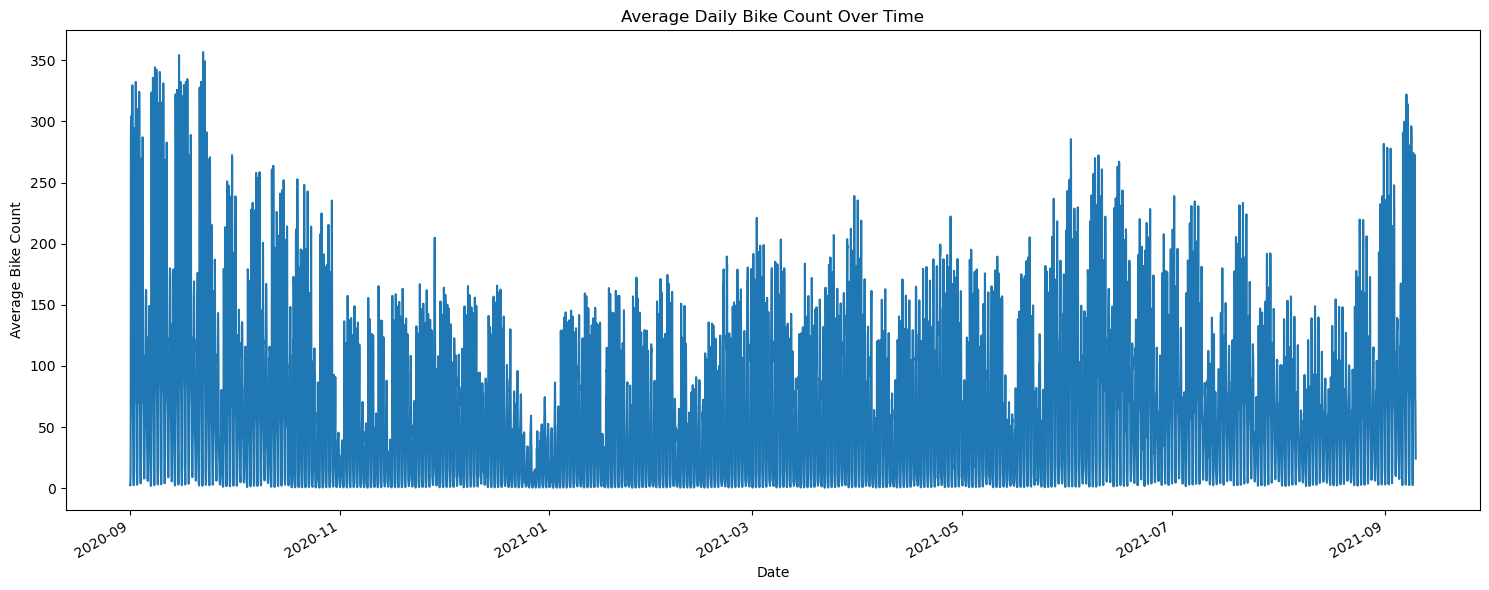

In [8]:
# Time Series View
plt.figure(figsize=(15, 6))
daily_counts = df.groupby('date')['bike_count'].mean()
daily_counts.plot()
plt.title('Average Daily Bike Count Over Time')
plt.xlabel('Date')
plt.ylabel('Average Bike Count')
plt.tight_layout()
plt.show()


This seems to confirm my view, for example we can look at around end of decemeber most people are in vacation, it's cold and there is a sharp drop in velib use...

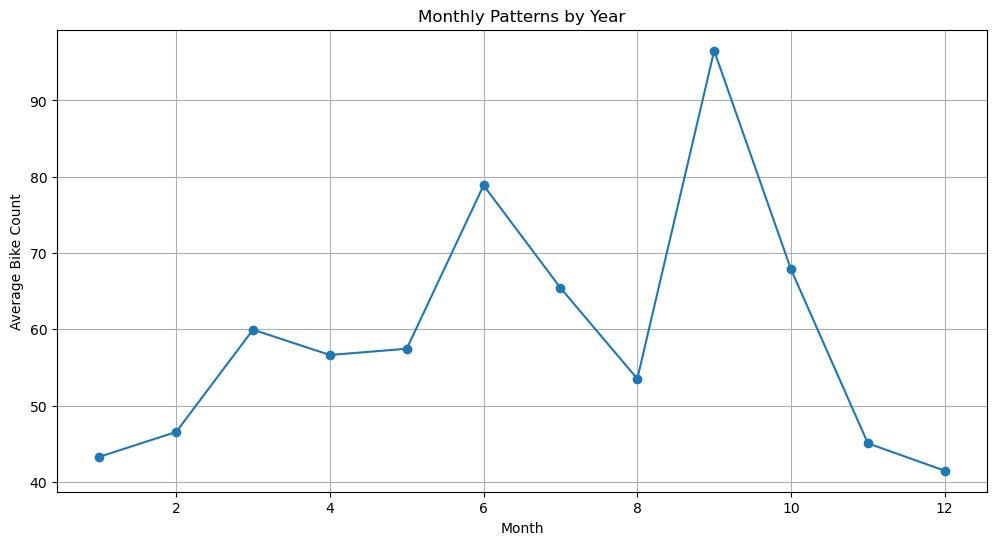

In [9]:
# Monthly patterns
monthly_traffic = df.groupby(['month'])['bike_count'].mean()
plt.figure(figsize=(12, 6))
monthly_traffic.T.plot(marker='o')
plt.title('Monthly Patterns by Year')
plt.xlabel('Month')
plt.ylabel('Average Bike Count')
plt.grid(True)
plt.show()

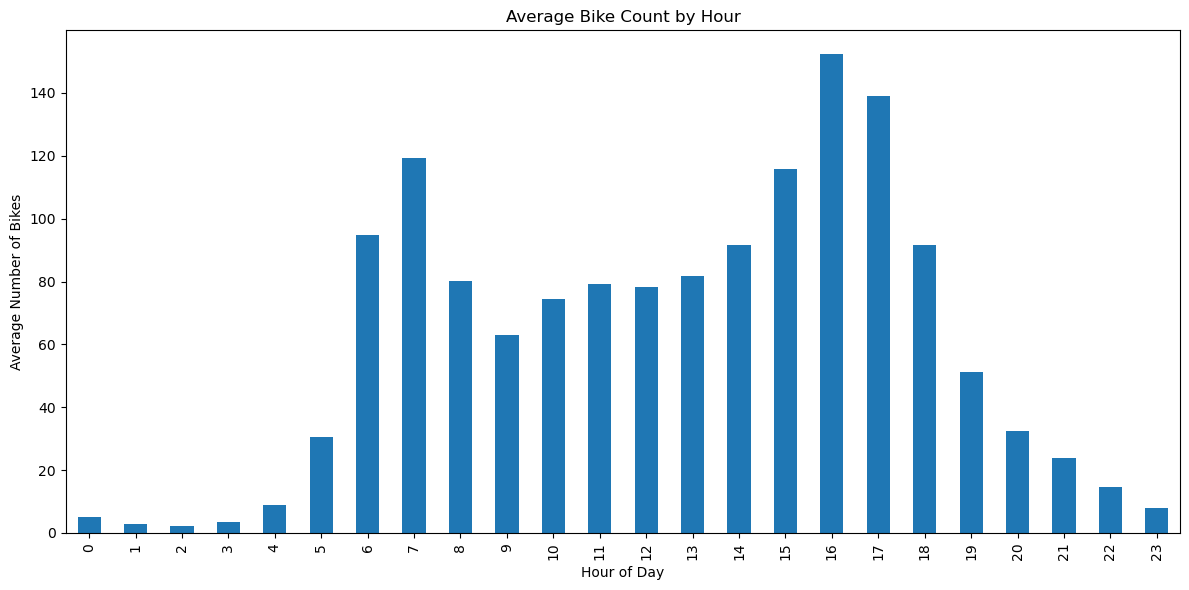

In [10]:
# Plot hourly patterns
plt.figure(figsize=(12, 6))
hourly_avg = df.groupby('hour')['bike_count'].mean()
hourly_avg.plot(kind='bar')
plt.title('Average Bike Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.tight_layout()
plt.show()

Velib are used for commuting to working  looking at the peak hours. Let's verify that by looking at weekdays/weekends and weekdays/holidays patterns an important difference will indicate different use.

<Figure size 1200x600 with 0 Axes>

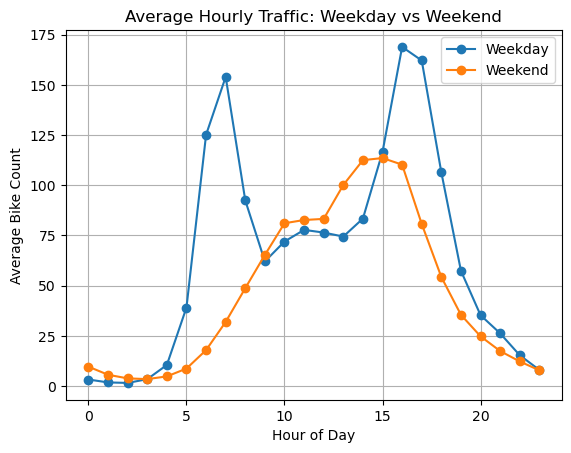

In [11]:
# Daily Patterns
hourly_traffic = df.groupby(['hour', 'is_weekend'])['bike_count'].mean().unstack()
plt.figure(figsize=(12, 6))
hourly_traffic.plot(marker='o')
plt.title('Average Hourly Traffic: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Bike Count')
plt.legend(['Weekday', 'Weekend'])
plt.grid(True)
plt.show()

In [12]:
holidays = pd.read_csv('external_data/Holidays/Propre_jours_feries.csv')
holidays['date'] = pd.to_datetime(holidays['date'])
holidays.dtypes

date    datetime64[ns]
dtype: object

In [13]:
df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)

<Figure size 1500x600 with 0 Axes>

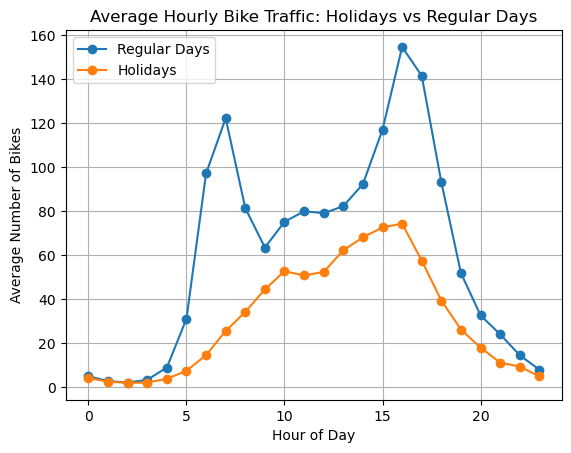

In [14]:
# Compare traffic patterns
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays'])
plt.grid(True)
plt.show()

The difference is even more important than with weekdays vs weekends.

In [15]:
# Read the holidays data
holidays_sco = pd.read_csv('external_data/Holidays/Propre_vacances_scolaires.csv')
holidays_sco.head()

,date
0,2017-10-20
1,2017-10-21
2,2017-10-22
3,2017-10-23
4,2017-10-24


In [16]:
holidays_sco['date'] = pd.to_datetime(holidays_sco['date'])
df['is_holiday_sco'] = df['date'].dt.date.isin(holidays_sco['date'].dt.date)

In [17]:
holidays_sco = holidays_sco[holidays_sco['date'].dt.year == 2021]
holidays_sco = holidays_sco.drop_duplicates()
len(holidays_sco)

133

<Figure size 1500x600 with 0 Axes>

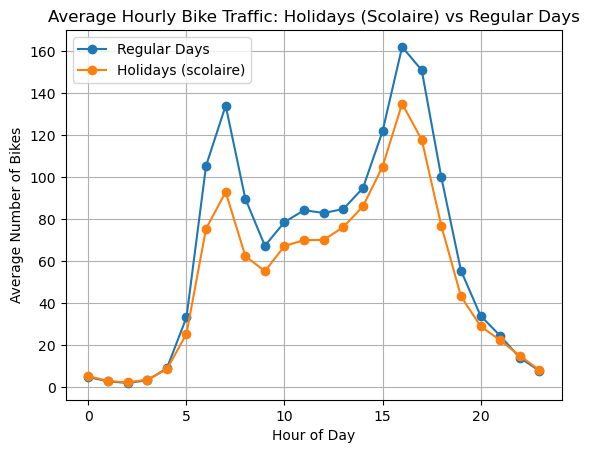

In [18]:
# 2. Compare traffic patterns vacances scolaires vs not vacances scolaires
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday_sco'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays (Scolaire) vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays (scolaire)'])
plt.grid(True)
plt.show()

The impact is less pronounced for holidays_sco than for bank holidays, indeed french childrens have quite a lot of holiday and adults don't always take their holidays at the same time (and have less). The information still seems to hold value so we will use it in our models.

We are considering using Cosine transformation to my data to better capture cyclical patterns. This is the analysis obtained (I decided not too keep the code because we will be dropping the use of most of these features)

We tried this encoding and checked its correlation with log_bikes

 Add cyclical encoding for hour (24-hour cycle)
- df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
- df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

 Add cyclical encoding for month (12-month cycle)
- df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
- df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

Add cyclical encoding for day_of_week (7-day cycle)
- df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
- df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

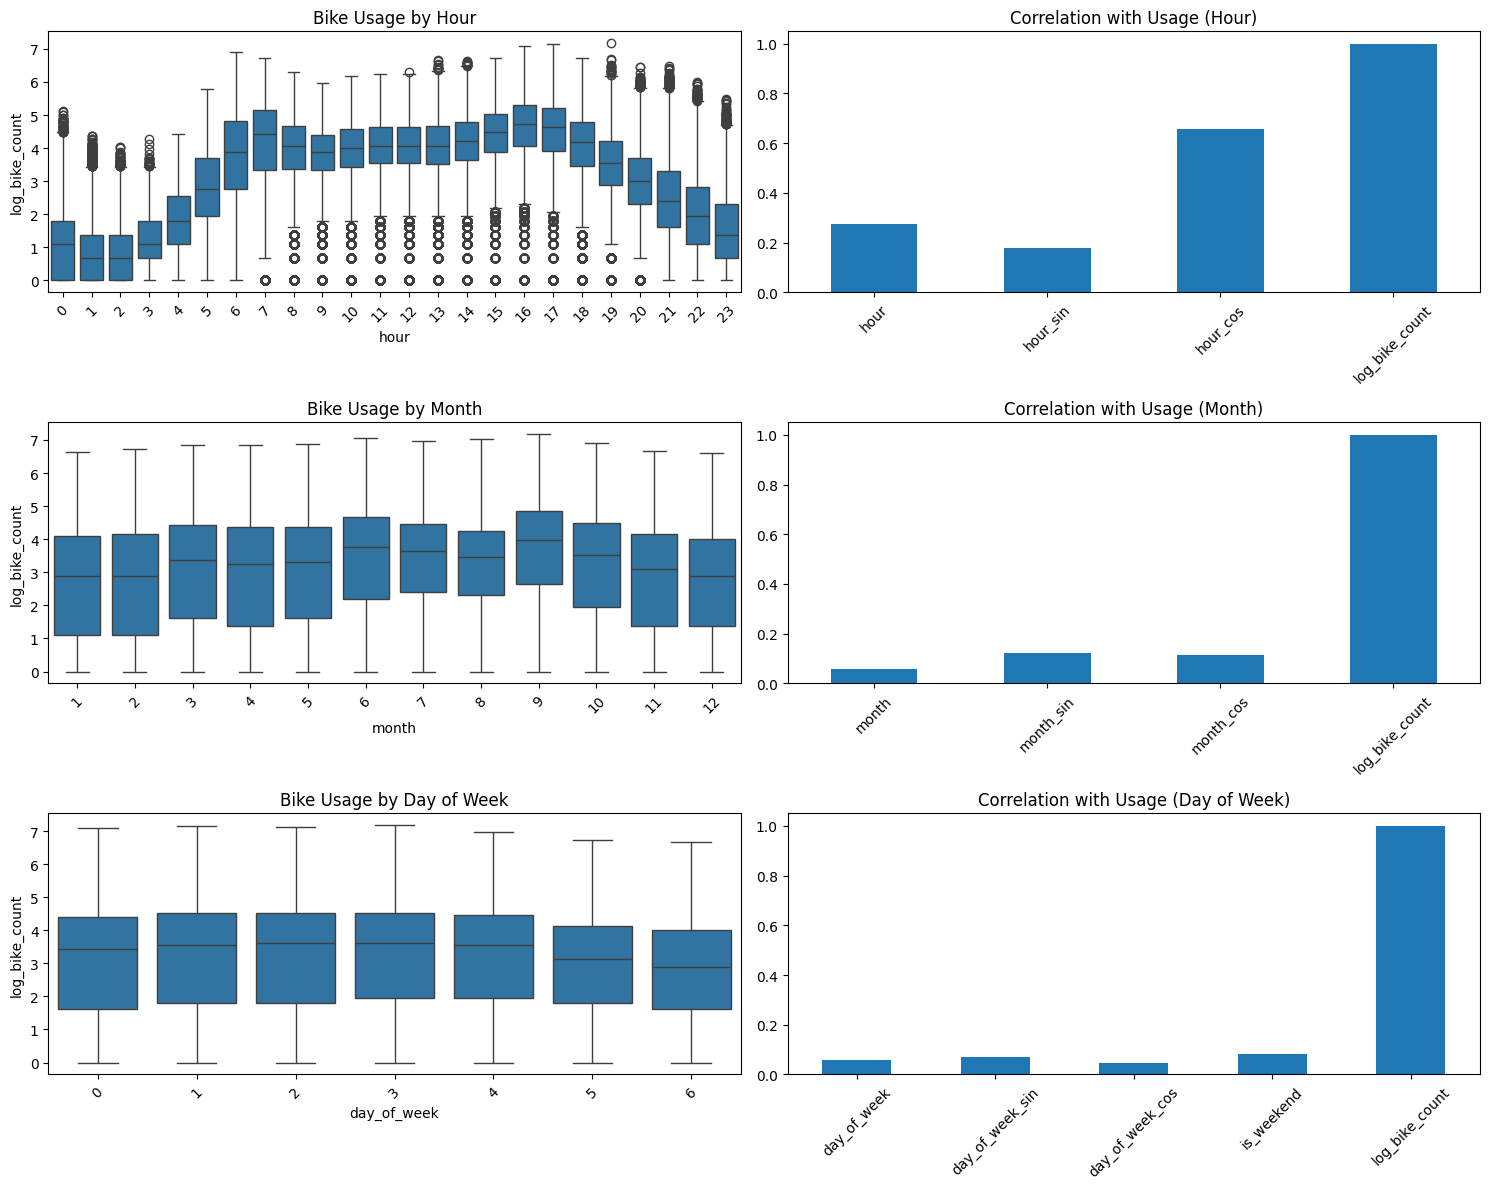

1. Let's keep:
- For the hour, let's replace the raw hour by the cos and sin transformation (high correlation). Keeping only one would make loose directionality
- For themonth, let's replace the raw month by the cos and sin transformation (high correlation). Keeping only one would make loose directionality
- For the day of the week, let's keep the raw data to avoid feature inflation

In [23]:
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,hour,day_of_week,month,weekday,is_weekend,is_holiday,is_holiday_sco
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2,1,9,Tuesday,False,False,False
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,3,1,9,Tuesday,False,False,False
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,4,1,9,Tuesday,False,False,False
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438,15,1,9,Tuesday,False,False,False
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585,18,1,9,Tuesday,False,False,False


In [28]:
df['date'] = pd.to_datetime(df['date']).dt.floor('h')


weather_df = pd.read_csv('external_data/Weather/Propre_meteo.csv')
covid_df = pd.read_csv('external_data/Covid/Propre_nbr_Covid.csv')

weather_df['date'] = pd.to_datetime(weather_df['date']).dt.floor('h')
covid_df['date'] = pd.to_datetime(covid_df['date']).dt.floor('h')

df = pd.merge(df, weather_df, on='date', how='left')
df = pd.merge(df, covid_df, on='date', how='left')

df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,Température de l'air,Humidité relative,Visibilité horizontale,Vitesse du vent,Précipitations horaires,Petite_pluie,Grosse_pluie,index_ressenti,new_covid,hour
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,12.75,81.0,30000.0,1.6,0.0,False,False,15.47,4982.0,2
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,10.95,88.0,25000.0,1.1,0.0,False,False,15.22,4982.0,3
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,10.95,88.0,25000.0,1.1,0.0,False,False,15.22,4982.0,4
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,20.65,41.0,30000.0,4.0,0.0,False,False,14.65,4982.0,15
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,19.15,47.0,30000.0,3.0,0.0,False,False,14.65,4982.0,18


In [25]:
df.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'log_bike_count',
       'Température de l'air', 'Humidité relative', 'Visibilité horizontale',
       'Vitesse du vent', 'Précipitations horaires', 'Petite_pluie',
       'Grosse_pluie', 'index_ressenti', 'new_covid', 'hour'],
      dtype='object')

In [ ]:
def create_engineered_features(df):
    """Create optimized feature set based on correlation analysis"""
    df = df.copy()

    #Import holidays data
    holidays = pd.read_csv('external_data/Holidays/Propre_jours_feries.csv')
    holidays_sco = pd.read_csv('external_data/Holidays/Propre_vacances_scolaires.csv')

    #Define holidays columns and holidays_sco
    holidays['date'] = pd.to_datetime(holidays['date'])
    df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)
    holidays_sco['date'] = pd.to_datetime(holidays_sco['date'])
    df['is_holiday_sco'] = df['date'].dt.date.isin(holidays_sco['date'].dt.date)

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.day_name()
    df['is_weekend'] = df['date'].dt.weekday >= 5

    # Keep only hour cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Create working day feature
    df['is_working_day'] = (~df['is_weekend']) & (~df['is_holiday'])
    # Create rush hour feature (only for working days)
    morning_rush = (df['hour'].between(6, 8)) & df['is_working_day']
    evening_rush = (df['hour'].between(15, 17)) & df['is_working_day']
    # Add rush hour binary feature
    df['is_rush_hour'] = (morning_rush | evening_rush).astype(bool)

    # Drop useless columns
    df = df.drop(columns='hour')
    df = df.drop(columns='month')
    df = df.drop(columns=['counter_id', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id'])


    # Define feature groups
    numeric_features = [
        'latitude',
        'longitude',
        'hour_sin',
        'hour_cos',
        'month_sin',
        'month_cos',
        "Température de l'air",
        'Humidité relative',
        'Visibilité horizontale',
        'Vitesse du vent',
        'Précipitations horaires',
        'index_ressenti',
        'new_covid'
    ]

    binary_features = [
        'is_weekend',
        'is_holiday',
        'is_holiday_sco',
        'is_working_day',
        'is_rush_hour',
        'Petite_pluie',
        'Grosse_pluie'
    ]

    categorical_features = ['counter_name', 'weekday']

    target = ['log_bike_count']

    reordered_columns = numeric_features + binary_features + categorical_features + target
    df = df.reindex(columns=reordered_columns)


    return df, numeric_features, binary_features, categorical_features

In [25]:
final_df, numeric_features, binary_features, categorical_features = create_engineered_features(df)
final_df.head()

,latitude,longitude,hour_sin,hour_cos,month_sin,month_cos,Température de l'air,Humidité relative,Visibilité horizontale,Vitesse du vent,...,is_weekend,is_holiday,is_holiday_sco,is_working_day,is_rush_hour,Petite_pluie,Grosse_pluie,counter_name,weekday,log_bike_count
0,48.846028,2.375429,0.500000,8.660254e-01,-1.0,-1.836970e-16,12.75,81.0,30000.0,1.6,...,False,False,False,True,False,False,False,28 boulevard Diderot E-O,Tuesday,0.000000
1,48.846028,2.375429,0.707107,7.071068e-01,-1.0,-1.836970e-16,10.95,88.0,25000.0,1.1,...,False,False,False,True,False,False,False,28 boulevard Diderot E-O,Tuesday,0.693147
2,48.846028,2.375429,0.866025,5.000000e-01,-1.0,-1.836970e-16,10.95,88.0,25000.0,1.1,...,False,False,False,True,False,False,False,28 boulevard Diderot E-O,Tuesday,0.000000
3,48.846028,2.375429,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,20.65,41.0,30000.0,4.0,...,False,False,False,True,False,False,False,28 boulevard Diderot E-O,Tuesday,1.609438
4,48.846028,2.375429,-1.000000,-1.836970e-16,-1.0,-1.836970e-16,19.15,47.0,30000.0,3.0,...,False,False,False,True,True,False,False,28 boulevard Diderot E-O,Tuesday,2.302585


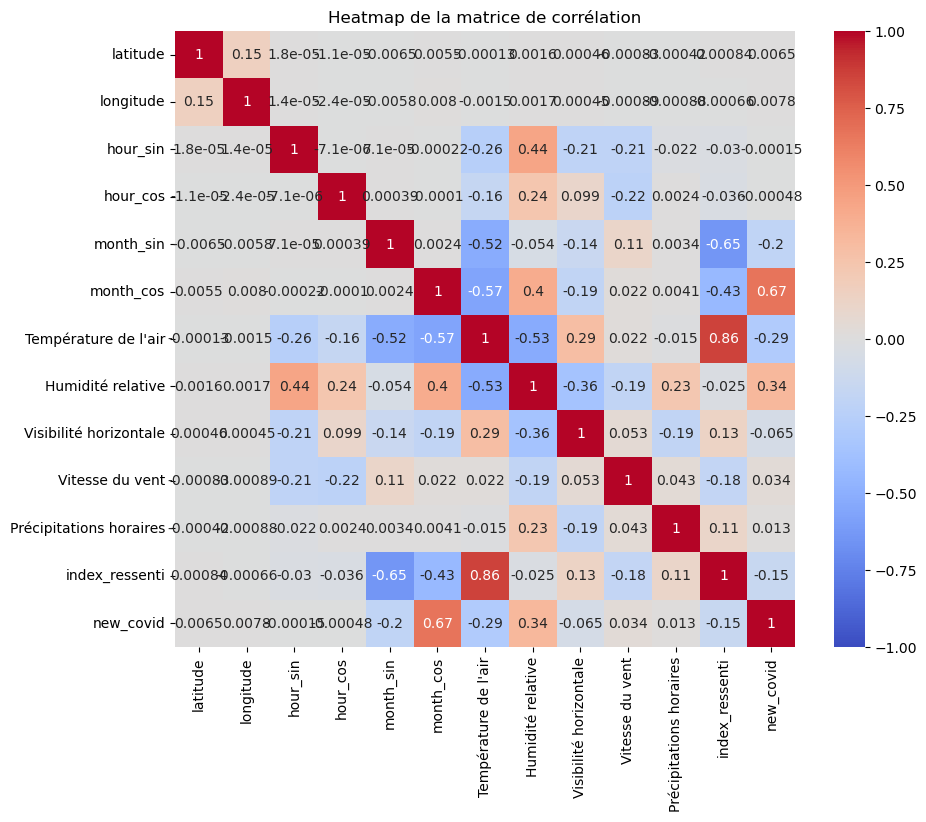

In [26]:
correlation_matrix = final_df[numeric_features].corr()
# Créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de la matrice de corrélation')
plt.show()

In [ ]:
X = final_df[numeric_features + categorical_features + binary_features]
y = final_df['log_bike_count']

class BikePredictor:
    def __init__(self):
        self.numeric_features = [
            'latitude',
            'longitude',
            'hour_sin',
            'hour_cos',
            'month_sin',
            'month_cos'
        ]

        self.binary_features = [
            'is_weekend',
            'is_holiday',
            'is_holiday_sco',
            'is_working_day',
            'is_rush_hour'
        ]

        self.categorical_features = [
            'counter_name',
            'weekday'
        ]

    def create_pipeline(self):
        # Add polynomial features for numeric variables
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features),
            ('bin', 'passthrough', self.binary_features)
        ])

        return Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge())
        ])

    def grid_search(self, X, y):
        # Expanded parameter grid
        param_grid = {
            'regressor__alpha': [1.0, 10.0, 100.0],
            'preprocessor__num__poly__degree': [1, 2]  # Try with and without polynomial features
        }

        # Time series split with more folds
        tscv = TimeSeriesSplit(n_splits=5, gap=24)  # gap of 24 hours

        # Create grid search
        grid_search = GridSearchCV(
            estimator=self.create_pipeline(),
            param_grid=param_grid,
            cv=tscv,
            scoring={
                'rmse': 'neg_root_mean_squared_error',
                'r2': 'r2'
            },
            refit='rmse',
            n_jobs=-1,
            verbose=1
        )

        # Fit grid search
        grid_search.fit(X, y)

        return grid_search

    def analyze_errors(self, model, X, y):
        """Analyze prediction errors to understand model weaknesses"""
        y_pred = model.predict(X)
        errors = y - y_pred

        error_analysis = pd.DataFrame({
            'true': y,
            'predicted': y_pred,
            'error': errors,
            'abs_error': np.abs(errors),
            'hour': X['hour'] if 'hour' in X.columns else None,
            'is_weekend': X['is_weekend'] if 'is_weekend' in X.columns else None
        })

        # Aggregate errors by different conditions
        analysis = {
            'overall_rmse': np.sqrt(np.mean(errors**2)),
            'weekend_rmse': error_analysis[error_analysis['is_weekend']]['abs_error'].mean(),
            'weekday_rmse': error_analysis[~error_analysis['is_weekend']]['abs_error'].mean(),
        }

        return analysis, error_analysis

predictor = BikePredictor()

# Perform grid search
grid_search = predictor.grid_search(X, y)

# Get best model
best_model = grid_search.best_estimator_

# Analyze errors
error_analysis, error_df = predictor.analyze_errors(best_model, X, y)

print("\nError Analysis:")
for metric, value in error_analysis.items():
    print(f"{metric}: {value:.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Error Analysis:
overall_rmse: 0.7904
weekend_rmse: 0.6087
weekday_rmse: 0.5717


In [49]:
grid_search.best_params_

{'preprocessor__num__poly__degree': 2, 'regressor__alpha': 1.0}

Looking at these error analysis results, let's interpret and make improvements:

The overall RMSE has improved to 0.7904 (better than previous 1.1585)
Weekend errors (0.6236) are slightly higher than weekday errors (0.5717)


From "Forecasting Bike Rental Demand" by Du et al., they found that hourly patterns have "clear variation between work days and weekends" and "certain hours (peak hours) will clearly have significantly more bike rentals than other hours."
From "A predictive analytics approach for forecasting bike rental demand" (Karunanithi et al.), analysis showed distinct usage patterns:

Weekday peak hours: 6-8 am and 4-7 pm showed heavy usage (commuting patterns)
Weekend peak hours: 10 am - 6 pm showed different patterns
Total rentals during peak hours comprised 28.19% of all rentals

The main arguments for separate models are:
Different Behaviors:
Peak hours are dominated by commuter patterns
Off-peak hours follow leisure/tourism patterns
Different features might be important at different times

In [ ]:
def perform_tscv(X, y, params, n_splits=5):
    """
    Perform time series cross validation for LightGBM model.

    Args:
        X: Features DataFrame
        y: Target Series
        params: LightGBM parameters
        n_splits: Number of splits for time series CV

    Returns:
        List of RMSE scores, trained model
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []

    # For plotting
    all_train_rmse = []
    all_val_rmse = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Create datasets
        train_set = lgb.Dataset(X_train, y_train)
        val_set = lgb.Dataset(X_val, y_val, reference=train_set)

        # Train model
        model = lgb.train(
            params,
            train_set,
            num_boost_round=1000,
            valid_sets=[train_set, val_set],
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
            valid_names=['train', 'valid']
        )

        # Make predictions
        val_preds = model.predict(X_val)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        rmse_scores.append(rmse)

        # Get training and validation scores for plotting
        train_preds = model.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))

        all_train_rmse.append(train_rmse)
        all_val_rmse.append(rmse)

        print(f'Fold {fold} - Train RMSE: {train_rmse:.4f}, Val RMSE: {rmse:.4f}')

    print('\nTime Series CV Results:')
    print(f'Average RMSE: {np.mean(rmse_scores):.4f} (+/- {np.std(rmse_scores):.4f})')

    return rmse_scores, model

## Let's try to identify the best models for our dataset

Since our dataset is too big to run an AutoML, let's start testing different Regressors algorithms iteratively with the default hyperparameters

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Boosting Libraries
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
# Dictionary of regression models
regressors = {
    "MLP Regressor": MLPRegressor(),
    "CatBoost Regressor": CatBoostRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "Light GBM Regressor": LGBMRegressor(),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boostin": GradientBoostingRegressor(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet()
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Pass binary features as they are
)

# Train-test split
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Store results
results = {}

# Iterate over models
for name, model in regressors.items():
    print(f"Training {name}...")

    # Define pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)

    # Fit and evaluate
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store results
    results[name] = {
        'CV RMSE Mean': rmse_scores.mean(),
        'CV RMSE Std': rmse_scores.std(),
        'Test RMSE': test_rmse

# Display results
results_df = pd.DataFrame(results).T
results_df.sort_values(by='Test RMSE', ascending=True, inplace=True)
results_df.head()

We obtain the folowwing results

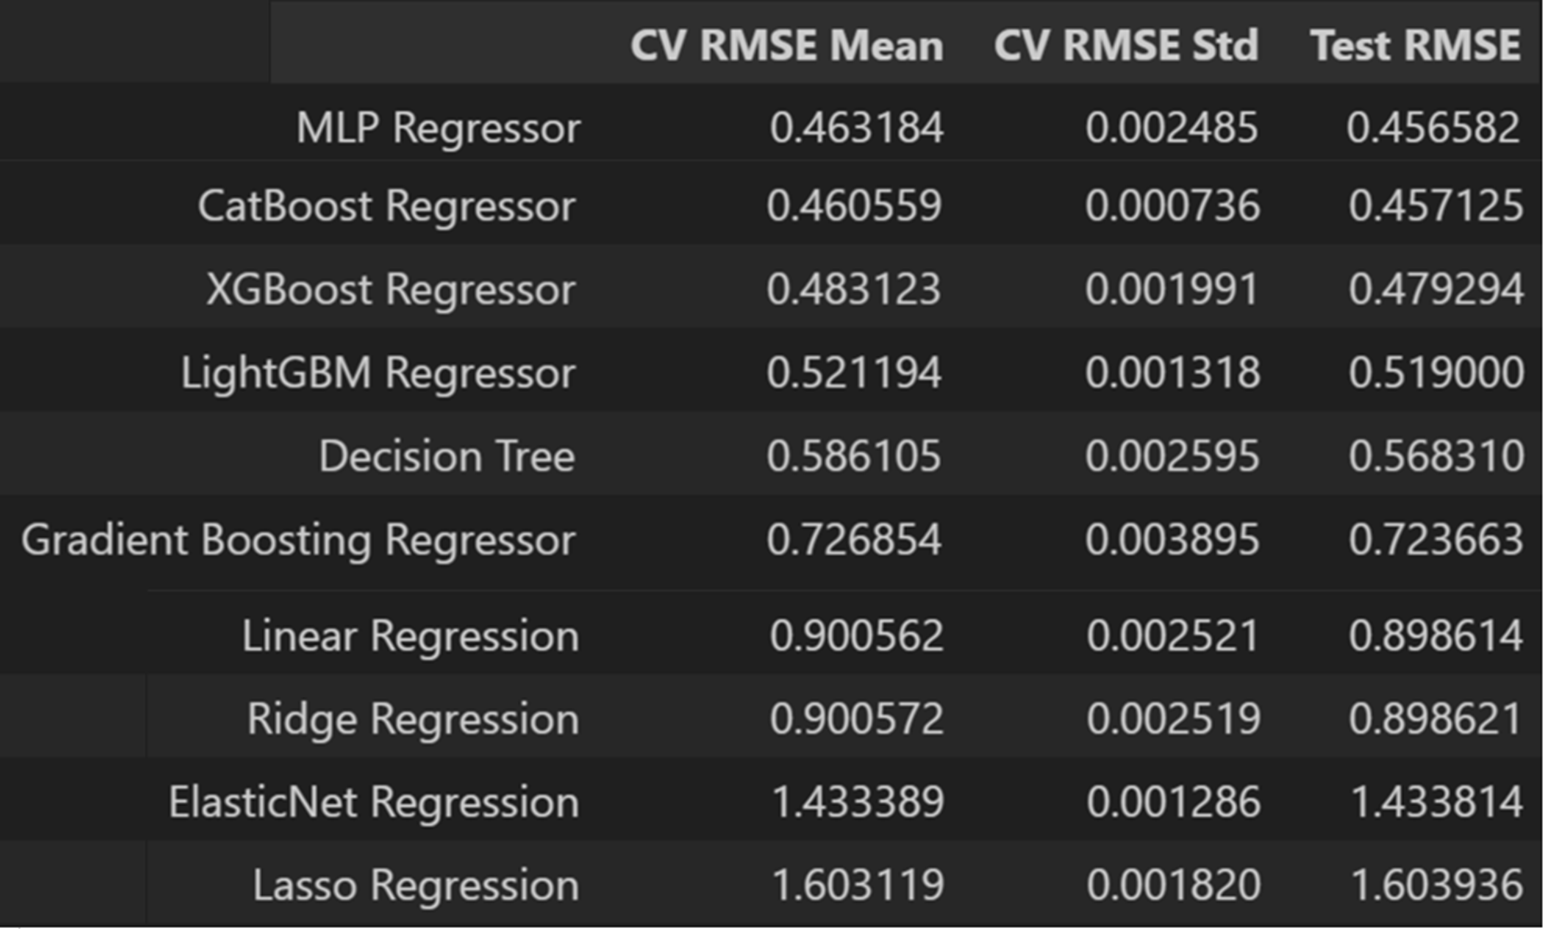


Considering theses results, we will try to fine-tune the hyperparameters of CatBoost Regressor, MLP Regressor and SGBoost Regressor

## Hyperparameters fine-tuning

Let's start with the CatBoost Regressor with the dataset without weather and covid data

In [ ]:
# Define the regressor and its hyperparameter search space
regressor_name = "CatBoost Regressor"
regressor = CatBoostRegressor(verbose=0)
hyperparams = {
    "iterations": lambda trial: trial.suggest_int('iterations', 100, 500),  # Reduced range
    "learning_rate": lambda trial: trial.suggest_float('learning_rate', 1e-5, 1e0, log=True),  # Reduced range
    "depth": lambda trial: trial.suggest_int('depth', 4, 8),  # Reduced range
    "l2_leaf_reg": lambda trial: trial.suggest_float('l2_leaf_reg', 1e-8, 1e0, log=True),  # Reduced range
    "bagging_temperature": lambda trial: trial.suggest_float('bagging_temperature', 1e-8, 1e0, log=True),  # Reduced range
    "random_strength": lambda trial: trial.suggest_float('random_strength', 1e-9, 10, log=True),  # Reduced range
    "border_count": lambda trial: trial.suggest_int('border_count', 32, 128),  # Reduced range
    "od_type": lambda trial: trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    "od_wait": lambda trial: trial.suggest_int('od_wait', 10, 30)  # Reduced range
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Pass binary features as they are
)

# Train-test split
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Use a smaller subset of the data for tuning
subset_size = 0.4  # Use 40% of the data
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=subset_size, random_state=1)

def objective(trial):
    model = regressor
    for param_name, param_func in hyperparams.items():
        model.set_params(**{param_name: param_func(trial)})

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    scores = cross_val_score(pipeline, X_train_subset, y_train_subset, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)  # Use all available CPUs

# Best trial
best_trial = study.best_trial
best_params = {k: v for k, v in best_trial.params.items()}

print(f"Best model: {regressor_name}")
print(f"Best hyperparameters: {best_params}")
print(f"CV RMSE Mean: {best_trial.value}")

# Train the best model with the best hyperparameters
best_model = regressor
best_model.set_params(**best_params)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {test_rmse}")

# Extract the trials and convert to DataFrame
trials_df = study.trials_dataframe()

# Sort the DataFrame by the objective value
trials_df_sorted = trials_df.sort_values(by='value')

# Display the sorted DataFrame
trials_df_sorted.head(20)

# Save the sorted DataFrame to a CSV file
trials_df_sorted.to_csv('optuna_CatBoost_trials_sorted.csv', index=False)

In [16]:
CatBoost_optuna_results = pd.read_csv("optuna_CatBoost_trials_sorted.csv")
CatBoost_optuna_results.head()

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_border_count,params_depth,params_iterations,params_l2_leaf_reg,params_learning_rate,params_od_type,params_od_wait,params_random_strength,state
0,86,0.449193,2024-12-05 16:01:49.339279,2024-12-05 16:08:04.638402,0 days 00:06:15.299123,0.449999,115,8,469,0.077964,0.236029,IncToDec,26,1.046349e-09,COMPLETE
1,87,0.449369,2024-12-05 16:01:52.756593,2024-12-05 16:07:59.958669,0 days 00:06:07.202076,0.009273,125,8,473,0.081841,0.233748,IncToDec,24,4.590410e-09,COMPLETE
2,85,0.449609,2024-12-05 16:00:43.059179,2024-12-05 16:07:00.212031,0 days 00:06:17.152852,0.431026,55,8,461,0.078487,0.206682,IncToDec,24,1.077725e-09,COMPLETE
3,84,0.449609,2024-12-05 16:00:41.296392,2024-12-05 16:07:00.158900,0 days 00:06:18.862508,0.223811,52,8,469,0.038772,0.137107,IncToDec,24,1.375481e-09,COMPLETE
4,76,0.449632,2024-12-05 15:48:57.120001,2024-12-05 15:54:49.391462,0 days 00:05:52.271461,0.000075,123,8,460,0.031153,0.227992,IncToDec,20,1.017937e-09,COMPLETE


Let's now start tuning the hyperparameters with the CatBoost Regressor with the dataset weather and covid, with a better adapted parameters tuning

In [ ]:
# Define the regressor and its hyperparameter search space
regressor_name = "CatBoost Regressor"
regressor = CatBoostRegressor(verbose=0)
hyperparams = {
    "iterations": lambda trial: trial.suggest_int('iterations', 100, 500),  # Reduced range
    "learning_rate": lambda trial: trial.suggest_float('learning_rate', 1e-5, 1e0, log=True),  # Reduced range
    "depth": lambda trial: trial.suggest_int('depth', 4, 8),  # Reduced range
    "l2_leaf_reg": lambda trial: trial.suggest_float('l2_leaf_reg', 1e-8, 1e0, log=True),  # Reduced range
    "bagging_temperature": lambda trial: trial.suggest_float('bagging_temperature', 1e-8, 1e0, log=True),  # Reduced range
    "random_strength": lambda trial: trial.suggest_float('random_strength', 1e-9, 10, log=True),  # Reduced range
    "border_count": lambda trial: trial.suggest_int('border_count', 32, 128),  # Reduced range
    "od_type": lambda trial: trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    "od_wait": lambda trial: trial.suggest_int('od_wait', 10, 30)  # Reduced range
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Pass binary features as they are
)

# Train-test split
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Use a smaller subset of the data for tuning
subset_size = 0.4  # Use 40% of the data
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=subset_size, random_state=1)

def objective(trial):
    model = regressor
    for param_name, param_func in hyperparams.items():
        model.set_params(**{param_name: param_func(trial)})

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    scores = cross_val_score(pipeline, X_train_subset, y_train_subset, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)  # Use all available CPUs

# Best trial
best_trial = study.best_trial
best_params = {k: v for k, v in best_trial.params.items()}

print(f"Best model: {regressor_name}")
print(f"Best hyperparameters: {best_params}")
print(f"CV RMSE Mean: {best_trial.value}")

# Train the best model with the best hyperparameters
best_model = regressor
best_model.set_params(**best_params)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {test_rmse}")

# Extract the trials and convert to DataFrame
trials_df = study.trials_dataframe()

# Sort the DataFrame by the objective value
trials_df_sorted = trials_df.sort_values(by='value')

# Display the sorted DataFrame
trials_df_sorted.head(20)

# Save the sorted DataFrame to a CSV file
trials_df_sorted.to_csv('optuna_CatBoost_trials_sorted.csv', index=False)

[I 2024-12-06 20:14:31,946] A new study created in memory with name: no-name-e0c72fd0-3699-49df-ae4a-20455e42a64d


In [8]:
CatBoost_optuna_results = pd.read_csv("global_optuna_CatBoost_trials_sorted.csv")
CatBoost_optuna_results.head()

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_border_count,params_depth,params_iterations,params_l2_leaf_reg,params_learning_rate,params_od_wait,params_random_strength,state
0,24,0.402930,2024-12-06 18:27:12.017224,2024-12-06 18:44:20.243064,0 days 00:17:08.225840,1.310077e-08,84,12,491,0.003506,0.151282,23,1.091170e-15,COMPLETE
1,39,0.403783,2024-12-06 19:17:07.553169,2024-12-06 19:32:31.958664,0 days 00:15:24.405495,3.831569e-08,128,12,498,0.001709,0.122758,26,3.810076e-14,COMPLETE
2,38,0.404000,2024-12-06 19:15:29.122780,2024-12-06 19:31:46.065013,0 days 00:16:16.942233,4.283384e-07,126,12,501,0.006052,0.113681,26,4.381007e-14,COMPLETE
3,37,0.404671,2024-12-06 19:14:11.523924,2024-12-06 19:29:55.394070,0 days 00:15:43.870146,9.004344e-02,52,10,500,0.001735,0.112741,21,3.372642e-14,COMPLETE
4,25,0.405279,2024-12-06 18:31:59.346980,2024-12-06 18:48:32.937048,0 days 00:16:33.590068,3.029733e-08,83,12,480,0.003132,0.139745,22,1.149101e-15,COMPLETE


Let's try tune our parameter with only the covid data (with the weather, the model performed less in our trials)

In [13]:
# Define the regressor and its hyperparameter search space
regressor_name = "CatBoost Regressor"
regressor = CatBoostRegressor(verbose=0, od_type='IncToDec')
hyperparams = {
    "iterations": lambda trial: trial.suggest_int('iterations', 400, 600),
    "learning_rate": lambda trial: trial.suggest_float('learning_rate', 1e-2, 1e0, log=True),
    "depth": lambda trial: trial.suggest_int('depth', 10, 15),
    "l2_leaf_reg": lambda trial: trial.suggest_float('l2_leaf_reg', 1e-4, 1e-2, log=True),
    "bagging_temperature": lambda trial: trial.suggest_float('bagging_temperature', 1e-10, 1e-6, log=True),
    "random_strength": lambda trial: trial.suggest_float('random_strength', 1e-20, 1e-15, log=True),
    "border_count": lambda trial: trial.suggest_int('border_count', 80, 160),
    "od_wait": lambda trial: trial.suggest_int('od_wait', 20, 30)
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Pass binary features as they are
)

# Train-test split
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Use a smaller subset of the data for tuning
subset_size = 0.2  # Use 20% of the data
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=subset_size, random_state=1)

def objective(trial):
    model = regressor
    for param_name, param_func in hyperparams.items():
        model.set_params(**{param_name: param_func(trial)})

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    scores = cross_val_score(pipeline, X_train_subset, y_train_subset, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40, n_jobs=-1)  # Use all available CPUs

# Best trial
best_trial = study.best_trial
best_params = {k: v for k, v in best_trial.params.items()}

print(f"Best model: {regressor_name}")
print(f"Best hyperparameters: {best_params}")
print(f"CV RMSE Mean: {best_trial.value}")

# Train the best model with the best hyperparameters
best_model = regressor
best_model.set_params(**best_params)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {test_rmse}")

# Extract the trials and convert to DataFrame
trials_df = study.trials_dataframe()

# Sort the DataFrame by the objective value
trials_df_sorted = trials_df.sort_values(by='value')

# Display the sorted DataFrame
trials_df_sorted.head(20)

# Save the sorted DataFrame to a CSV file
trials_df_sorted.to_csv('covid_optuna_CatBoost_trials_sorted.csv', index=False)

[I 2024-12-07 09:55:22,473] A new study created in memory with name: no-name-c4b316ba-4082-4a98-bd3b-5f8edc0fd443
[I 2024-12-07 10:45:58,532] Trial 1 finished with value: 0.4621264723849542 and parameters: {'iterations': 404, 'learning_rate': 0.2728861595101505, 'depth': 10, 'l2_leaf_reg': 0.00046948400538790984, 'bagging_temperature': 6.512599566485542e-09, 'random_strength': 3.69890874966178e-17, 'border_count': 146, 'od_wait': 27}. Best is trial 1 with value: 0.4621264723849542.
[I 2024-12-07 10:50:19,275] Trial 0 finished with value: 0.4621264723849542 and parameters: {'iterations': 412, 'learning_rate': 0.61668365384108, 'depth': 10, 'l2_leaf_reg': 0.000172556761373401, 'bagging_temperature': 6.594191253232079e-08, 'random_strength': 5.629860890502495e-20, 'border_count': 90, 'od_wait': 21}. Best is trial 1 with value: 0.4621264723849542.
[I 2024-12-07 10:54:55,911] Trial 2 finished with value: 0.4689200917861049 and parameters: {'iterations': 519, 'learning_rate': 0.2028445450677

Best model: CatBoost Regressor
Best hyperparameters: {'iterations': 461, 'learning_rate': 0.11116321661474277, 'depth': 11, 'l2_leaf_reg': 0.00020200201446673102, 'bagging_temperature': 3.887812068795712e-10, 'random_strength': 1.5978885715672066e-18, 'border_count': 92, 'od_wait': 22}
CV RMSE Mean: 0.4352109167268674
Test RMSE: 0.4018342915939269


In [14]:
CatBoost_optuna_results = pd.read_csv("covid_optuna_CatBoost_trials_sorted.csv")
CatBoost_optuna_results.head()

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_border_count,params_depth,params_iterations,params_l2_leaf_reg,params_learning_rate,params_od_wait,params_random_strength,state
0,28,0.435211,2024-12-07 12:42:35.166555,2024-12-07 12:52:28.061147,0 days 00:09:52.894592,3.887812e-10,92,11,461,0.000202,0.111163,22,1.597889e-18,COMPLETE
1,29,0.435340,2024-12-07 12:43:48.204684,2024-12-07 13:59:26.850560,0 days 01:15:38.645876,4.628450e-10,108,12,462,0.000250,0.101250,22,1.163519e-18,COMPLETE
2,30,0.437310,2024-12-07 12:47:04.601779,2024-12-07 14:02:20.078098,0 days 01:15:15.476319,4.126447e-10,135,12,430,0.000236,0.111738,26,1.343793e-17,COMPLETE
3,34,0.438343,2024-12-07 14:02:20.098460,2024-12-07 14:25:02.260277,0 days 00:22:42.161817,4.368790e-10,109,12,429,0.000219,0.087975,22,1.089346e-17,COMPLETE
4,33,0.438639,2024-12-07 13:59:26.858599,2024-12-07 14:07:43.714825,0 days 00:08:16.856226,4.132727e-10,110,12,434,0.000466,0.064254,22,1.854833e-18,COMPLETE


In [9]:
# Define the regressor and its hyperparameter search space
regressor_name = "CatBoost Regressor"
regressor = CatBoostRegressor(verbose=0, od_type='IncToDec')
hyperparams = {
    "iterations": lambda trial: trial.suggest_int('iterations', 400, 600),
    "learning_rate": lambda trial: trial.suggest_float('learning_rate', 0.05, 0.3, log=True),
    "depth": lambda trial: trial.suggest_int('depth', 7, 12),
    "l2_leaf_reg": lambda trial: trial.suggest_float('l2_leaf_reg', 1e-5, 1e-4, log=True),
    "bagging_temperature": lambda trial: trial.suggest_float('bagging_temperature', 1e-13, 1e-11, log=True),
    "random_strength": lambda trial: trial.suggest_float('random_strength', 1e-19, 1e-17, log=True),
    "border_count": lambda trial: trial.suggest_int('border_count', 100, 140),
    "od_wait": lambda trial: trial.suggest_int('od_wait', 21, 24)
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Pass binary features as they are
)

# Train-test split
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Use a smaller subset of the data for tuning
subset_size = 0.6  # Use 60% of the data
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=subset_size, random_state=1)

def objective(trial):
    model = regressor
    for param_name, param_func in hyperparams.items():
        model.set_params(**{param_name: param_func(trial)})

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    scores = cross_val_score(pipeline, X_train_subset, y_train_subset, scoring='neg_mean_squared_error', cv=2)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20, n_jobs=-1)  # Use all available CPUs

# Best trial
best_trial = study.best_trial
best_params = {k: v for k, v in best_trial.params.items()}

print(f"Best model: {regressor_name}")
print(f"Best hyperparameters: {best_params}")
print(f"CV RMSE Mean: {best_trial.value}")

# Train the best model with the best hyperparameters
best_model = regressor
best_model.set_params(**best_params)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {test_rmse}")

# Extract the trials and convert to DataFrame
trials_df = study.trials_dataframe()

# Sort the DataFrame by the objective value
trials_df_sorted = trials_df.sort_values(by='value')

# Display the sorted DataFrame
trials_df_sorted.head(20)

# Save the sorted DataFrame to a CSV file
trials_df_sorted.to_csv('global_rush_optuna_CatBoost_trials_sorted.csv', index=False)

[I 2024-12-09 19:22:59,713] A new study created in memory with name: no-name-eedefc1e-6fde-4bd9-a7d9-80bce4e74416
[I 2024-12-09 19:30:33,636] Trial 0 finished with value: 0.3868060309334226 and parameters: {'iterations': 583, 'learning_rate': 0.1847740721763271, 'depth': 10, 'l2_leaf_reg': 4.1041813617646755e-05, 'bagging_temperature': 8.597764833009229e-13, 'random_strength': 1.0016086594143372e-19, 'border_count': 112, 'od_wait': 22}. Best is trial 0 with value: 0.3868060309334226.
[I 2024-12-09 19:30:38,982] Trial 3 finished with value: 0.3863914359839167 and parameters: {'iterations': 493, 'learning_rate': 0.2657473319615264, 'depth': 11, 'l2_leaf_reg': 2.3875283877085346e-05, 'bagging_temperature': 2.083137932973687e-13, 'random_strength': 1.9264537635271165e-19, 'border_count': 123, 'od_wait': 23}. Best is trial 3 with value: 0.3863914359839167.
[I 2024-12-09 19:30:47,620] Trial 2 finished with value: 0.3863914359839167 and parameters: {'iterations': 567, 'learning_rate': 0.06914

Best model: CatBoost Regressor
Best hyperparameters: {'iterations': 599, 'learning_rate': 0.09725724713613478, 'depth': 12, 'l2_leaf_reg': 1.6384420991828588e-05, 'bagging_temperature': 9.976950137687865e-12, 'random_strength': 7.437524697350354e-19, 'border_count': 107, 'od_wait': 22}
CV RMSE Mean: 0.38219466655696577
Test RMSE: 0.35263015955220933


In [10]:
CatBoost_optuna_results = pd.read_csv("global_rush_optuna_CatBoost_trials_sorted.csv")
CatBoost_optuna_results.head()

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_border_count,params_depth,params_iterations,params_l2_leaf_reg,params_learning_rate,params_od_wait,params_random_strength,state
0,19,0.382195,2024-12-09 20:48:29.358012,2024-12-09 20:54:56.204451,0 days 00:06:26.846439,9.976950e-12,107,12,599,0.000016,0.097257,22,7.437525e-19,COMPLETE
1,4,0.384801,2024-12-09 19:30:33.648521,2024-12-09 19:41:05.130552,0 days 00:10:31.482031,7.651234e-12,103,12,465,0.000017,0.163314,24,2.666743e-19,COMPLETE
2,7,0.385288,2024-12-09 19:30:47.652372,2024-12-09 19:39:57.447020,0 days 00:09:09.794648,5.938544e-13,122,10,488,0.000035,0.246869,23,1.789679e-19,COMPLETE
3,6,0.385288,2024-12-09 19:30:47.635415,2024-12-09 19:40:14.484568,0 days 00:09:26.849153,4.921221e-12,102,12,585,0.000016,0.070282,22,4.735595e-18,COMPLETE
4,9,0.386193,2024-12-09 19:40:14.501375,2024-12-09 19:48:12.853707,0 days 00:07:58.352332,2.187709e-12,117,11,552,0.000098,0.079274,24,1.659373e-18,COMPLETE
